# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Baseline Models

Today we work on the simplest models to act as a starting point that we will beat.

In [1]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
# And more imports for our NLP related machine learning

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [6]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [7]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [8]:
%matplotlib inline

# Loading the pkl files

Let's avoid curating all our data again! Load in the pickle files

If you didn't already create these in Day 2, you can also download them from my google drive (you'll also find the slides here):  
https://drive.google.com/drive/folders/1JwNorpRHdnf_pU0GE5yYtfKlyrKC3CoV?usp=sharing

But note that the files are quite large - you might need to get a coffee!

In [9]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [10]:
# Remind ourselves the training prompt

print(train[0].prompt)

How much does this cost to the nearest dollar?

Bose SoundLink Bluetooth Mobile Speaker II
Enjoy your music on the go with this Bose SoundLink wireless mobile speaker that features Bluetooth technology for an easy connection to compatible devices. The integrated bifold cover unfolds into a stand to enable versatile placement. This refurbished product is tested and certified to look and work like new. The refurbishing process includes functionality testing, basic cleaning, inspection, and repackaging. The product ships with all relevant accessories, and may arrive in a generic box Dimensions 13.3 x 7.5 x 5.5 inches, Weight 4.44 pounds, model number Batteries 1 Lithium Ion batteries required., Rank Electronics 55339, Portable Bluetooth Speakers 1594, Is Discontinued No, Available July 23, 2014, Manufacturer

Price is $158.00


In [11]:
# Remind a test prompt

print(train[0].price)

158.0


## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [12]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

# Now for something basic

What's the very simplest model you could imagine?

Let's start with a random number generator!

In [13]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $138.00 Error: $517.00 SLE: 2.41 Item: Habisder 2022 Laptops 14.1'' Laptop Comp...
2: Guess: $115.00 Truth: $399.99 Error: $284.99 SLE: 1.54 Item: 10" 1080P Backup Camera Monitor & Built-...
3: Guess: $26.00 Truth: $149.99 Error: $123.99 SLE: 2.96 Item: Avolusion PRO-5X Series 12TB USB 3.0 Ext...
4: Guess: $760.00 Truth: $73.05 Error: $686.95 SLE: 5.43 Item: LG EBF61215202 Genuine OEM Lid Switch As...
5: Guess: $282.00 Truth: $68.97 Error: $213.03 SLE: 1.95 Item: LG EBF62174902 LG-EBF62174902 Switch,Rot...
6: Guess: $251.00 Truth: $839.00 Error: $588.00 SLE: 1.45 Item: CyberpowerPC Gamer Master Gaming PC, AMD...
7: Guess: $229.00 Truth: $80.99 Error: $148.01 SLE: 1.06 Item: Herdio 5.25 Inch Wall Mount Passive Spea...
8: Guess: $143.00 Truth: $18.98 Error: $124.02 SLE: 3.90 Item: FitTurn Compatible with SKG V7 V7 Pro Ba...
9: Guess: $755.00 Truth: $23.99 Error: $731.01 SLE: 11.63 Item: TRUMiRR Watch Band for Fenix 7 Sapphire ...
10: Guess: $105.00 Truth: $78.99 

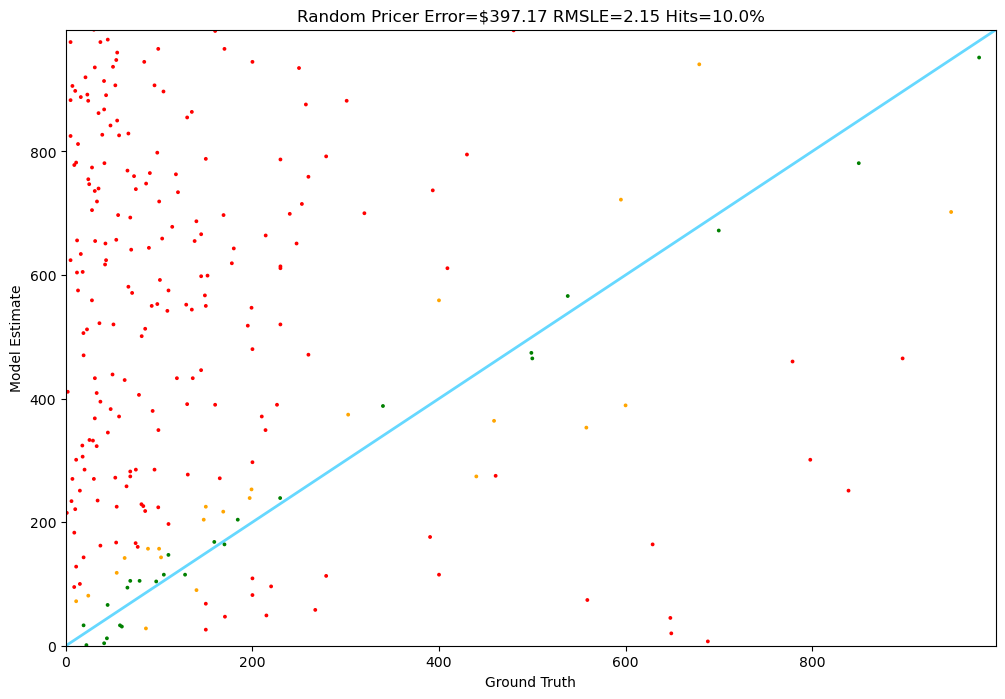

In [14]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

In [15]:
# That was fun!
# We can do better - here's another rather trivial model

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $159.90 Truth: $138.00 Error: $21.90 SLE: 0.02 Item: Habisder 2022 Laptops 14.1'' Laptop Comp...
2: Guess: $159.90 Truth: $399.99 Error: $240.09 SLE: 0.83 Item: 10" 1080P Backup Camera Monitor & Built-...
3: Guess: $159.90 Truth: $149.99 Error: $9.91 SLE: 0.00 Item: Avolusion PRO-5X Series 12TB USB 3.0 Ext...
4: Guess: $159.90 Truth: $73.05 Error: $86.85 SLE: 0.60 Item: LG EBF61215202 Genuine OEM Lid Switch As...
5: Guess: $159.90 Truth: $68.97 Error: $90.93 SLE: 0.69 Item: LG EBF62174902 LG-EBF62174902 Switch,Rot...
6: Guess: $159.90 Truth: $839.00 Error: $679.10 SLE: 2.73 Item: CyberpowerPC Gamer Master Gaming PC, AMD...
7: Guess: $159.90 Truth: $80.99 Error: $78.91 SLE: 0.45 Item: Herdio 5.25 Inch Wall Mount Passive Spea...
8: Guess: $159.90 Truth: $18.98 Error: $140.92 SLE: 4.35 Item: FitTurn Compatible with SKG V7 V7 Pro Ba...
9: Guess: $159.90 Truth: $23.99 Error: $135.91 SLE: 3.47 Item: TRUMiRR Watch Band for Fenix 7 Sapphire ...
10: Guess: $159.90 Truth: $78.99 Error:

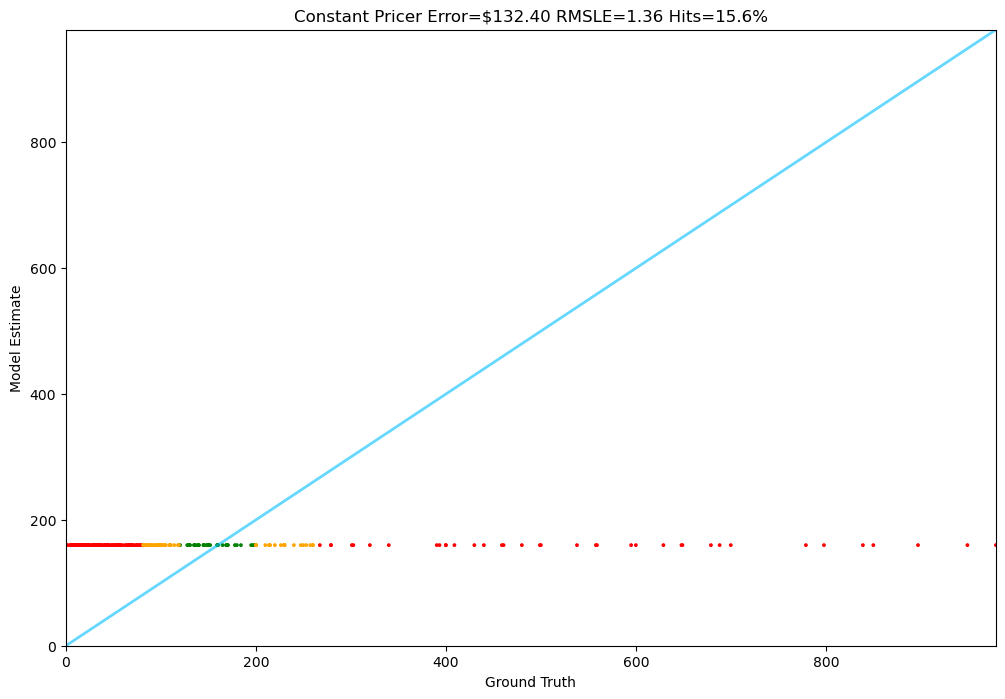

In [16]:
# Run our constant predictor
Tester.test(constant_pricer)


In [17]:
train[0].details

'{"Product Dimensions": "13.3 x 7.5 x 5.5 inches", "Item Weight": "4.44 pounds", "Item model number": "559301", "Batteries": "1 Lithium Ion batteries required.", "Best Sellers Rank": {"Electronics": 55339, "Portable Bluetooth Speakers": 1594}, "Is Discontinued By Manufacturer": "No", "Date First Available": "July 23, 2014", "Manufacturer": "Bose", "Brand": "Bose", "Model Name": "SoundLink", "Speaker Type": "Outdoor", "Connectivity Technology": "Bluetooth", "Special Feature": "Wireless"}'

In [ ]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [ ]:
train[0].features.keys()

In [ ]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

In [ ]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [ ]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [ ]:
average_weight = sum(weights)/len(weights)
average_weight

In [ ]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [ ]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [ ]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

In [ ]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [ ]:
def get_text_length(item):
    return len(item.test_prompt())

In [ ]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

In [ ]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [ ]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [ ]:
# Look at features in a training item
get_features(train[0])

In [ ]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [ ]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

In [ ]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

In [ ]:
# test it

Tester.test(linear_regression_pricer)

In [ ]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [ ]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

In [ ]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

In [ ]:
# test it

Tester.test(bow_lr_pricer)

In [ ]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [ ]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [ ]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

In [ ]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

In [ ]:
Tester.test(word2vec_lr_pricer)

In [ ]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

In [ ]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

In [ ]:
Tester.test(svr_pricer)

In [ ]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

In [ ]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

In [ ]:
Tester.test(random_forest_pricer)